# Step 1: Load Data

In [1]:
import sys
import os
from transformers import AutoTokenizer
from pathlib import Path

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.dataset.scdnam_dataset import TokensRatiosDataset, scDNAm_collate_TokensRatios

tokenizer = AutoTokenizer.from_pretrained(f"../src/tokenizers/scdnam_6mer", trust_remote_code=True)
human_body = {}
human_body["humanbody_testset_sample"] = TokensRatiosDataset(
    csv_file="human_body/data/humanbody_testset_sample.csv",
    root_path="human_body/data/scWGBS_with_nucleotide_change_10mer_tokens_npz",
    K_mer="6mer", tokenizer=tokenizer, type_json_path="human_body/data/human_body_type.json",
    need_labels=True,
    need_analysis=True,
    max_length = 20_000_000,  # A100 (80GB) handles 10M, H200 handles 20M. Set to 2M (almost covered) CpGs for quick testing.
    random=False,
    use_sample=False,
    use_truncation=False,
    start_idx=0,
    selective_chrs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
)
data_collator = scDNAm_collate_TokensRatios(tokenizer=tokenizer)

output_dir = Path("output_dir")
output_dir.mkdir(parents=True, exist_ok=True)

/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
human_body["humanbody_testset_sample"][0]

{'unmethy_input_ids': array([  0, 375, 503, ..., 355, 245,   2]),
 'methy_input_ids': array([  0, 376, 504, ..., 356, 246,   2]),
 'methy_ratios': array([1.        , 1.        , 1.        , ..., 1.        , 0.66666669,
        1.        ]),
 'positions': array([       0,    17478,    17483, ..., 50779013, 50808026,        0]),
 'chrs': array([ 0,  1,  1, ..., 22, 22,  0]),
 'file_names': 'SB_JF1O2/SB_JF1O2_AR_Plate3-2-J3-L16.allc_processed.npz',
 'labels': 0}

# Step 2: Load Model

In [3]:
from inference.inference import scDNAmGPTForAnalysis

model = scDNAmGPTForAnalysis.from_pretrained(
    tokenizer=tokenizer,
    pretrained_model_name="human_body/model",
    num_labels=human_body["humanbody_testset_sample"].num_labels,
    attention_mechanism={
      "projection_dim": 256,
      "attention_num_heads": 8,
      "dropout_rate": 0.1}
)

# Move model to device
device = "cuda:0"
model.to(device)  
model.eval() 

------------------------------------------
Shape of lm_head.weight:  torch.Size([520, 128]) 
------------------------------------------
[Missing keys]:
  - lm_head.weight


scDNAmGPTForAnalysis(
  (backbone): scDNAmMixerModel(
    (embedding): Embedding(520, 128)
    (layers): ModuleList(
      (0-7): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=128, out_features=520, bias=False)
  (query_proj): Linear(in_features=128, out_features=256, bias=True)
  (key_proj): Linear(in_features=128, out_features=256, bias=True)
  (value_proj): Linear(in_features=128, out_features=256, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuanti

# Step 3: Inference

In [4]:
from inference.inference import run_inference_on_dataset

run_inference_on_dataset(
    model, human_body["humanbody_testset_sample"], tokenizer, data_collator, 
    device, output_dir, "humanbody_testset_sample", 
    batch_size=1
)

/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/scDNAm-GPT/inference/inference.py:308: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(), torch.no_grad():
Inferencing: 100%|████████████████████| 700/700 [03:55<00:00,  2.98batch/s, current_samples=1/700, latest_file=TrCo_A9VP4...]


In [5]:
import pandas as pd

# Load the dataset
file_path = 'output_dir/humanbody_testset_sample/humanbody_testset_sample_inference_results.csv'
df = pd.read_csv(file_path)

# Calculate the accuracy where labels == predictions
accuracy = (df['labels'] == df['predictions']).mean()

accuracy

0.9814285714285714

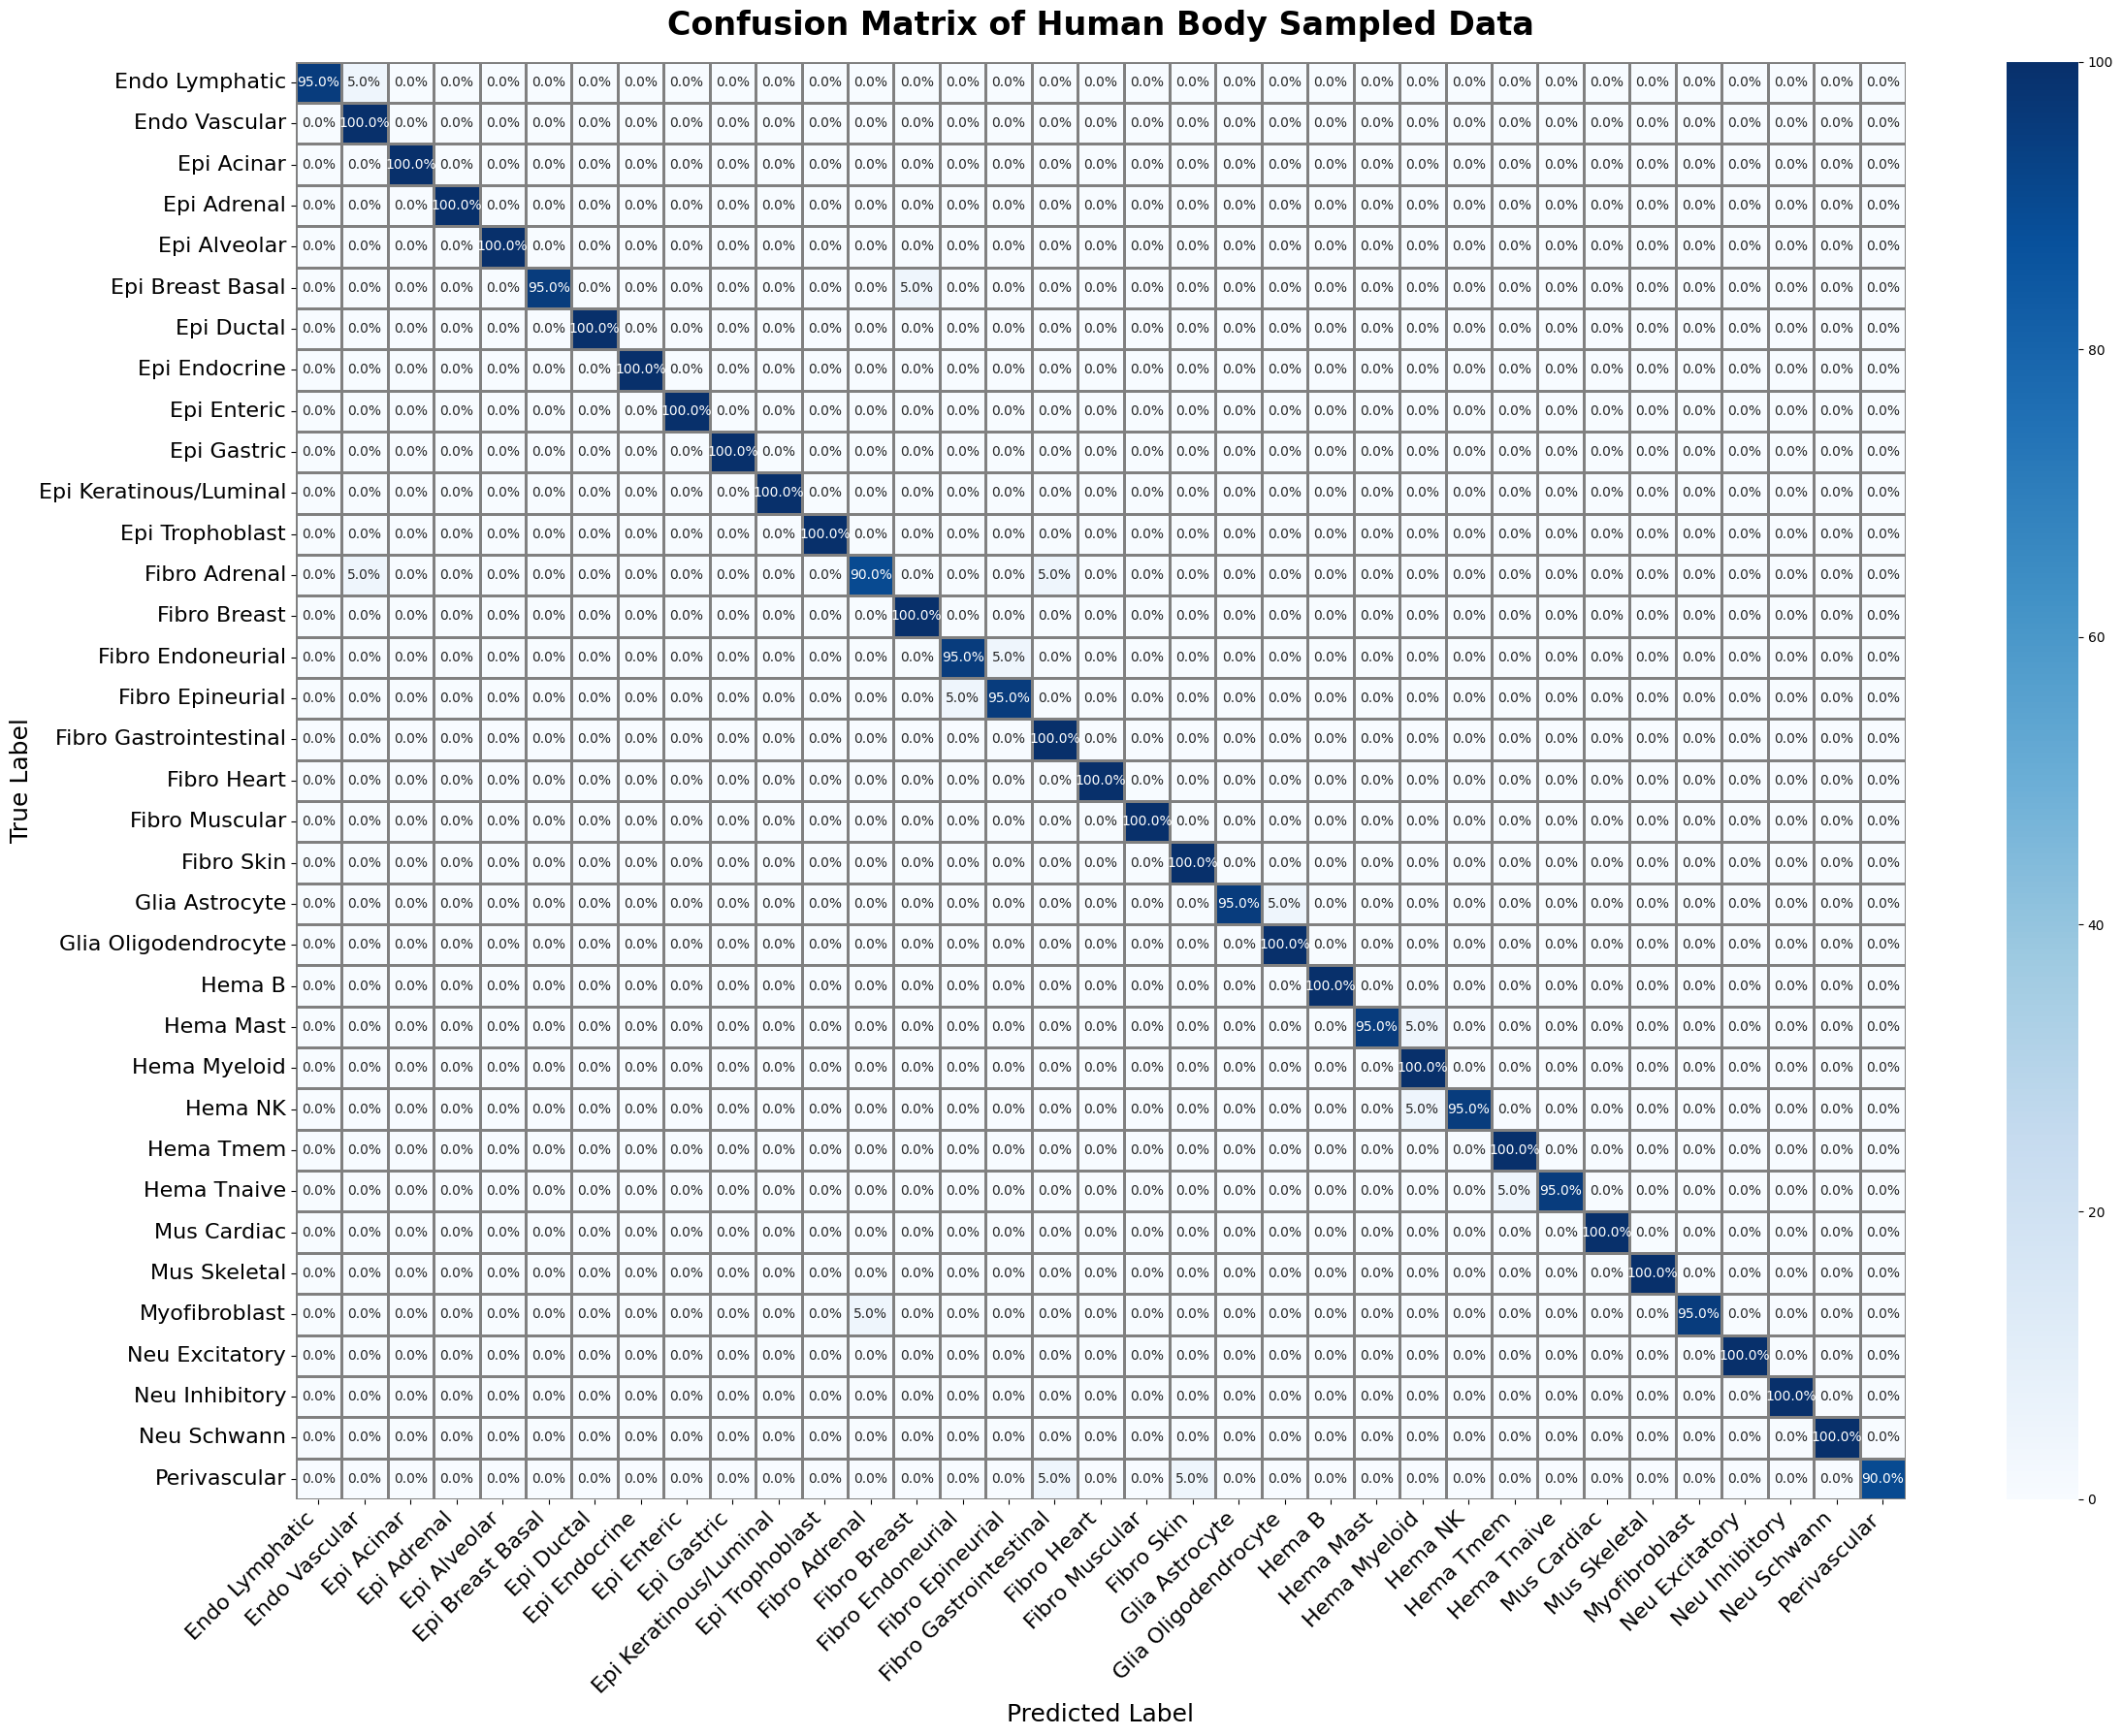

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import seaborn as sns

df = pd.read_csv("output_dir/humanbody_testset_sample/humanbody_testset_sample_inference_results.csv")  # 您的完整路径

all_classes = sorted(set(df['labels']).union(set(df['predictions'])))
full_cm = confusion_matrix(df['labels'], df['predictions'], labels=all_classes)

# Load mapping from numeric label to text label
with open("human_body/data/human_body_type.json", "r", encoding="utf-8") as f:
    celltype_to_id = json.load(f)

labels = celltype_to_id.keys()

# 计算百分比
confusion_matrix_percentage = full_cm.astype('float') / full_cm.sum(axis=1)[:, np.newaxis] * 100

# 格式化每个格子的注释，加上百分号
annotations = np.array([['{:.1f}%'.format(value) for value in row] for row in confusion_matrix_percentage])

# 绘制热图
plt.figure(figsize=(24, 18))
ax = sns.heatmap(
    confusion_matrix_percentage,
    annot=annotations,
    fmt='',
    cmap='Blues',
    cbar=True,
    linewidths=0.8,
    linecolor='grey',
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 10}
)

# 设置标题和轴标签
ax.set_title('Confusion Matrix of Human Body Sampled Data', fontsize=24, pad=20, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=18)
ax.set_ylabel('True Label', fontsize=18)

# 设置坐标轴刻度字体大小
ax.set_xticklabels(labels, fontsize=16, rotation=45, ha="right")
ax.set_yticklabels(labels, fontsize=16, rotation=0)

# 保持布局紧凑
plt.tight_layout()

# Step 4: Cell Embeddings

In [7]:
# === Minimal version: CSV -> array loading -> AnnData ===
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad


# ---------- Config ----------
CSV_PATH  = "output_dir/humanbody_testset_sample/humanbody_testset_sample_inference_results.csv"
DATA_DIR  = "output_dir/humanbody_testset_sample/norm_attn_outputs"
CELLTYPE_ID = "human_body/data/human_body_type.json"
FILTER_MATCHED = False  # If CSV has 'predictions' and you only want rows where labels==predictions, set True

# Numeric label -> text label

# Load mapping from numeric label to text label
with open(CELLTYPE_ID, "r", encoding="utf-8") as f:
    celltype_to_id = json.load(f)

# Directly reverse the dictionary
LABEL_MAP = {v: k for k, v in celltype_to_id.items()}

# ---------- Utilities ----------
def load_array(path: str):
    """Load .npz/.npy; if 2D+, reduce via axis=0 sum; convert sparse to dense; return 1D ndarray."""
    if not os.path.exists(path):
        return None
    try:
        obj = np.load(path, allow_pickle=True)
        if isinstance(obj, np.lib.npyio.NpzFile):
            key = "data" if "data" in obj.files else obj.files[0]
            arr = obj[key]
        else:
            arr = obj  # .npy is already an ndarray

        if sp.issparse(arr):
            arr = arr.toarray()

        if arr.ndim > 1:
            arr = arr.sum(axis=0)  # aggregate to a 1D feature vector across layers

        return np.asarray(arr).ravel()
    except Exception as e:
        print(f"[skip] {os.path.basename(path)} -> {e}")
        return None

def build_anndata(csv_path: str, data_dir: str, filter_matched: bool = False):
    df = pd.read_csv(csv_path)

    if filter_matched and {"labels", "predictions"}.issubset(df.columns):
        df = df[df["labels"] == df["predictions"]]

    X, obs_rows = [], []
    missing = 0

    for _, row in df.iterrows():
        file_name = row["file_name"]
        label_id = row["labels"]
        path = os.path.join(data_dir, file_name)

        arr = load_array(path)
        if arr is None:
            missing += 1
            continue

        X.append(arr)
        obs_rows.append({"file_name": file_name, "label_id": label_id})

    if not X:
        return None, {"n_rows": 0, "n_features": 0, "missing": missing}

    X = np.vstack(X)
    obs = pd.DataFrame(obs_rows)
    obs["cell_type"] = obs["label_id"].map(LABEL_MAP)

    adata = ad.AnnData(X=X, obs=obs[["file_name", "cell_type", "label_id"]])
    return adata, {"n_rows": X.shape[0], "n_features": X.shape[1], "missing": missing}

# ---------- Main ----------
adata, info = build_anndata(CSV_PATH, DATA_DIR, filter_matched=FILTER_MATCHED)

if adata is None or info["n_rows"] == 0:
    print("No matching data found. Cannot create AnnData.")
else:
    print(f"AnnData: {info['n_rows']} cells × {info['n_features']} features (skipped {info['missing']} missing/corrupted files)")
    # Optional save:
    adata.write(f"{output_dir}/humanbody_testset_sample/humanbody_testset_sample.h5ad")

AnnData: 700 cells × 256 features (skipped 0 missing/corrupted files)


/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


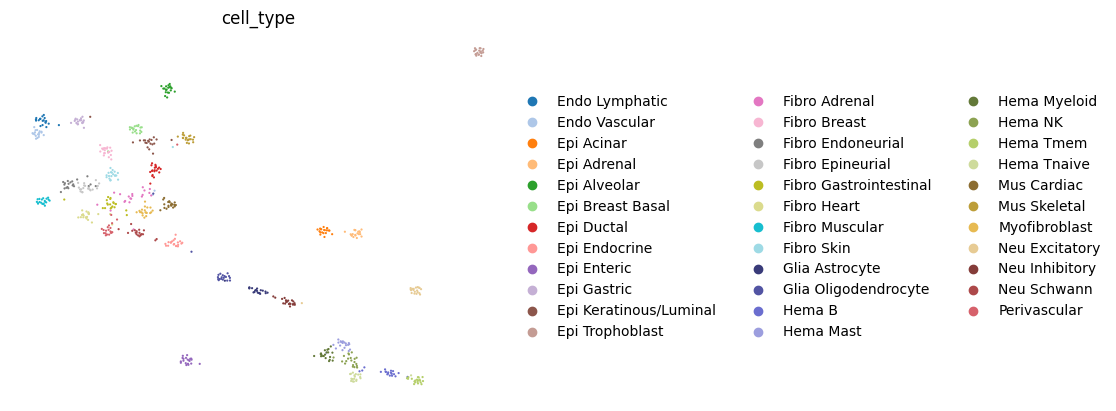

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt

# Suppress verbose logging
sc.settings.verbosity = 0 

# Load h5ad file
adata = sc.read_h5ad(f"{output_dir}/humanbody_testset_sample/humanbody_testset_sample.h5ad")

# Run PCA -> compute neighbors -> UMAP
sc.pp.pca(adata, n_comps=64, random_state=42)
sc.pp.neighbors(adata, n_pcs=32, n_neighbors=16, random_state=42)
sc.tl.umap(adata, random_state=42)

# generating 35 colors
import seaborn as sns
palette_35 = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 15)  # 共35个

# cell_type → color
unique_celltypes = adata.obs["cell_type"].unique().tolist()
palette_dict = {ct: palette_35[i] for i, ct in enumerate(unique_celltypes)}

# Plot UMAP
sc.pl.umap(
    adata,
    color="cell_type",
    size=10,
    frameon=False,
    palette=palette_dict
)

plt.show()
